In [218]:
import pyforest

1. Understanding & Inspecting the Data


In [219]:
df = pd.read_csv("Cars_Datasets 2025.csv", encoding="cp1252")
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


In [220]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


In [221]:
print("Shape:",df.shape)

Shape: (1218, 11)


In [222]:
print((df.isnull().sum() / len(df)) * 100)


Company Names                0.000000
Cars Names                   0.000000
Engines                      0.000000
CC/Battery Capacity          0.246305
HorsePower                   0.000000
Total Speed                  0.000000
Performance(0 - 100 )KM/H    0.492611
Cars Prices                  0.000000
Fuel Types                   0.000000
Seats                        0.000000
Torque                       0.082102
dtype: float64


In [223]:
df["Cars Prices"] = extract_numeric(df["Cars Prices"])
df["HorsePower"] = extract_numeric(df["HorsePower"])
df["Torque"] = extract_numeric(df["Torque"])
df["Total Speed"] = extract_numeric(df["Total Speed"])
df["Performance(0 - 100 )KM/H"] = extract_numeric(df["Performance(0 - 100 )KM/H"])

In [224]:
df["Seats"] = (
    df["Seats"].astype(str)
    .str.replace(r'[^0-9\-]', '', regex=True)   # keep digits and dash
    .apply(lambda x: np.mean([int(i) for i in x.split('-')]) if '-' in x and x.replace('-', '').isdigit() else x)
)
df["Seats"] = pd.to_numeric(df["Seats"], errors="coerce")


In [225]:
import re

def clean_numeric(value):
    if pd.isna(value):
        return None
    # keep digits and dots only
    val = re.sub(r'[^0-9.]', '', str(value))
    # if multiple dots, keep only the first
    if val.count('.') > 1:
        first, *rest = val.split('.')
        val = first + '.' + ''.join(rest)
    try:
        return float(val) if val else None
    except:
        return None

df["CC/Battery Capacity"] = df["CC/Battery Capacity"].apply(clean_numeric)


In [226]:
df["Company Names"] = df["Company Names"].astype("category")
df["Cars Names"]    = df["Cars Names"].astype("category")
df["Engines"]       = df["Engines"].astype("category")
df["Fuel Types"]    = df["Fuel Types"].astype("category")

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Company Names              1218 non-null   category
 1   Cars Names                 1218 non-null   category
 2   Engines                    1218 non-null   category
 3   CC/Battery Capacity        1213 non-null   float64 
 4   HorsePower                 1137 non-null   float64 
 5   Total Speed                1218 non-null   float64 
 6   Performance(0 - 100 )KM/H  1202 non-null   float64 
 7   Cars Prices                1049 non-null   float64 
 8   Fuel Types                 1218 non-null   category
 9   Seats                      1218 non-null   int64   
 10  Torque                     1195 non-null   float64 
dtypes: category(4), float64(6), int64(1)
memory usage: 128.5 KB


In [228]:
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990.0,963.0,340.0,2.5,1100000.0,plug in hyrbrid,2,800.0
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563.0,250.0,5.3,460000.0,Petrol,5,900.0
2,Ford,KA+,1.2L Petrol,1200.0,NaN,165.0,10.5,NaN,Petrol,5,NaN
3,MERCEDES,GT 63 S,V8,3982.0,630.0,250.0,3.2,161000.0,Petrol,4,900.0
4,AUDI,AUDI R8 Gt,V10,5204.0,602.0,320.0,3.6,253290.0,Petrol,2,560.0


In [229]:
df.describe(include='all')

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
count,1218,1218,1218,1.213000e+03,1137.000000,1218.000000,1202.000000,1.049000e+03,1218,1218.000000,1195.000000
unique,37,1201,356,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
top,Nissan,Golf Cabriolet,I4,NaN,NaN,NaN,NaN,NaN,Petrol,NaN,NaN
freq,149,2,64,NaN,NaN,NaN,NaN,NaN,871,NaN,NaN
mean,NaN,NaN,NaN,1.573429e+07,1130.387863,216.467159,7.569468,1.471626e+07,NaN,5.403120,1757.065272
std,NaN,NaN,NaN,1.717775e+08,12303.232288,53.051077,3.322024,2.467175e+08,NaN,8.983463,17056.525246
min,NaN,NaN,NaN,1.240000e+00,26.000000,80.000000,1.900000,4.000000e+03,NaN,1.000000,45.000000
25%,NaN,NaN,NaN,1.595000e+03,159.000000,180.000000,5.200000,3.000000e+04,NaN,4.000000,250.000000
50%,NaN,NaN,NaN,2.494000e+03,272.000000,200.000000,7.100000,4.700000e+04,NaN,5.000000,380.000000
75%,NaN,NaN,NaN,3.996000e+03,402.000000,250.000000,9.500000,8.249500e+04,NaN,5.000000,567.000000


In [230]:
df["Cars Prices"].mean()

np.float64(14716258.95042898)

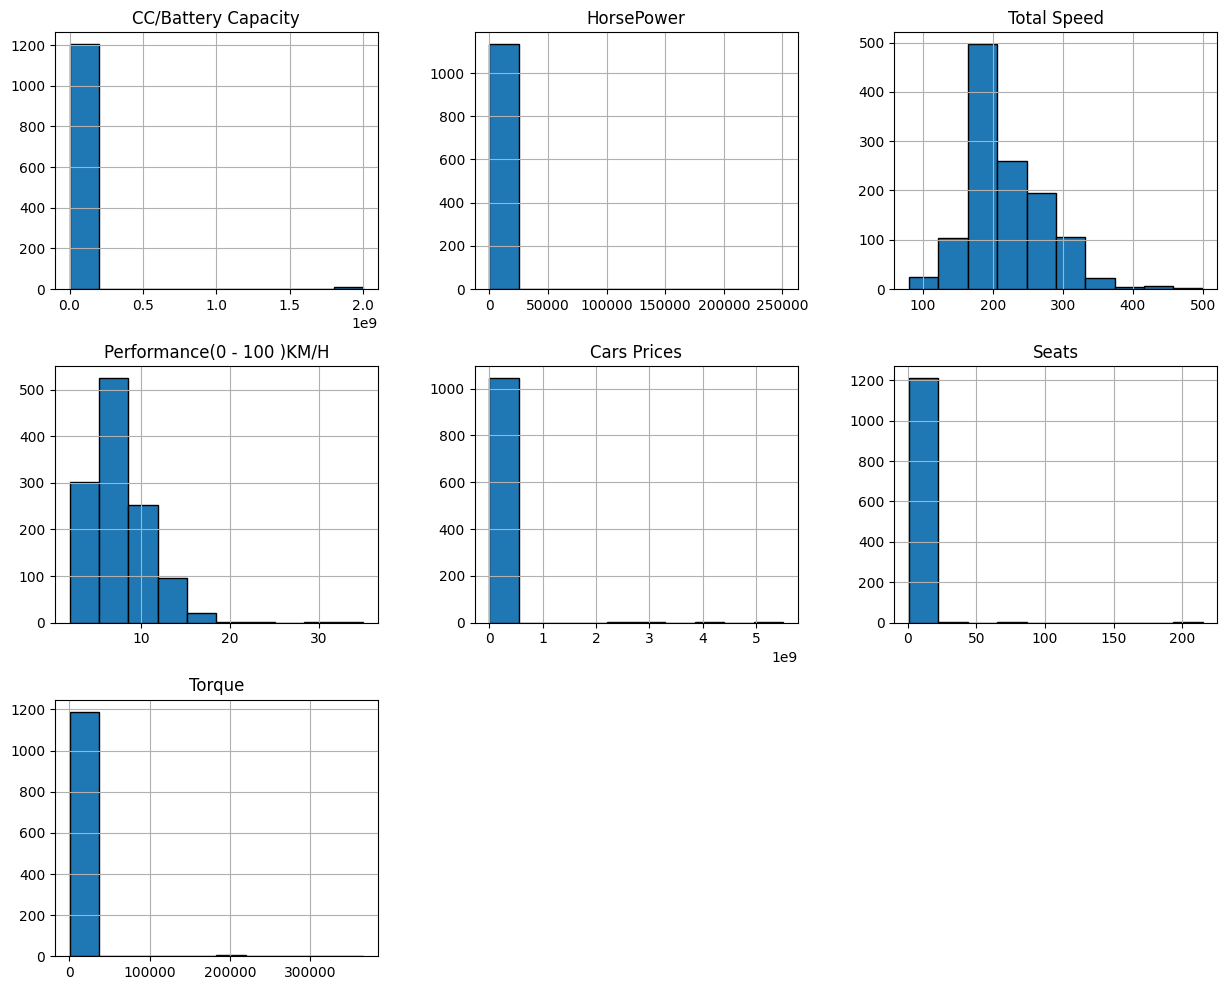

In [231]:
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

df[numeric_cols].hist(bins=10, figsize=(15, 12), edgecolor='black')
plt.title("Histograms of Numeric Columns", fontsize=10)
plt.show()

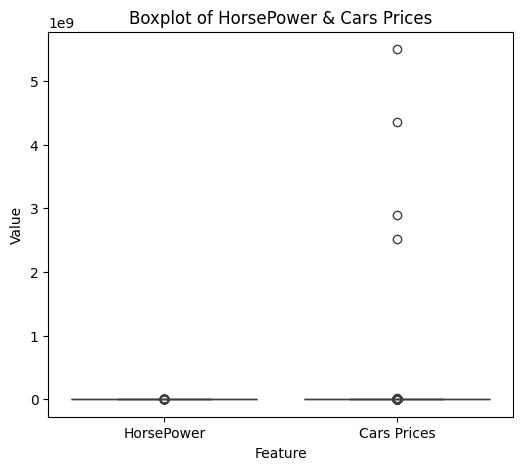

In [232]:
cols_to_plot = ["HorsePower", "Cars Prices"]
df_melted = df[cols_to_plot].melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(6, 5))
sns.boxplot(x="Feature", y="Value", data=df_melted)
plt.title("Boxplot of HorsePower & Cars Prices")
plt.show()

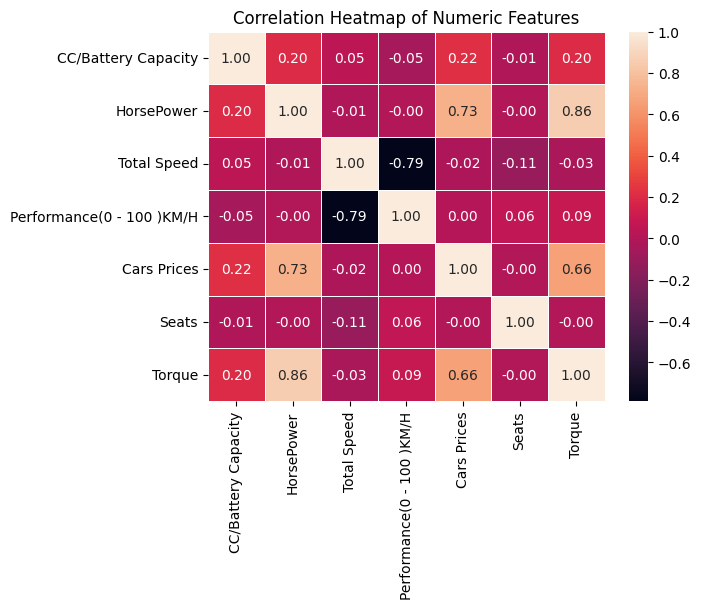

In [233]:
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

2. Handling Missing Data


In [234]:
print(df.isnull().sum())
print((df.isnull().sum() / len(df)) * 100)


Company Names                  0
Cars Names                     0
Engines                        0
CC/Battery Capacity            5
HorsePower                    81
Total Speed                    0
Performance(0 - 100 )KM/H     16
Cars Prices                  169
Fuel Types                     0
Seats                          0
Torque                        23
dtype: int64
Company Names                 0.000000
Cars Names                    0.000000
Engines                       0.000000
CC/Battery Capacity           0.410509
HorsePower                    6.650246
Total Speed                   0.000000
Performance(0 - 100 )KM/H     1.313629
Cars Prices                  13.875205
Fuel Types                    0.000000
Seats                         0.000000
Torque                        1.888342
dtype: float64
